# Логистическая регрессия

Задача - собрать свою собственную логистическую регрессию с блэкджеком и кроссэнтропией.

Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [ ]:
import theano
import theano.tensor as T
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target

print "y [shape - %s]:"%(str(y.shape))
print "X [shape - %s]:"%(str(X.shape))

y [shape - (360L,)]:
X [shape - (360L, 64L)]:


In [30]:
# переменные и входы
shared_weights = theano.shared(np.zeros(64, dtype='float64'))
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='float64')

In [31]:
predicted_y = 1/(1+ T.exp(-T.dot(input_X, shared_weights)))
loss = -T.sum(input_y*T.log(predicted_y) + (1-input_y)*T.log(1-predicted_y))

grad = T.grad(loss,shared_weights)

update = shared_weights - 0.00001 * grad

updates = {
    shared_weights: update
}

In [32]:
inputs=[input_X,input_y]
outputs=loss
train_function = theano.function(inputs, outputs, updates=updates)
inputs=[input_X]
outputs=predicted_y
predict_function = theano.function(inputs, outputs)

In [33]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

loss at iter 0:187.1497
train auc: 1.0
test auc: 1.0
loss at iter 1:119.3218
train auc: 1.0
test auc: 1.0
loss at iter 2:86.1469
train auc: 1.0
test auc: 1.0
loss at iter 3:67.5347
train auc: 1.0
test auc: 1.0
loss at iter 4:55.8021
train auc: 1.0
test auc: 1.0
resulting weights:


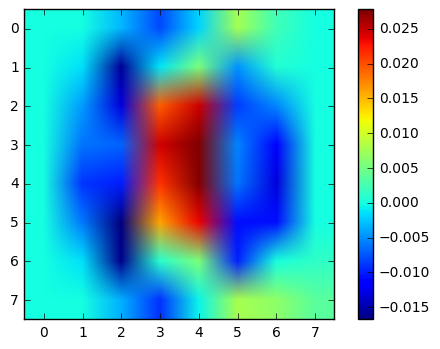

In [34]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print "loss at iter %i:%.4f"%(i,loss_i)
    print "train auc:",roc_auc_score(y_train,predict_function(X_train))
    print "test auc:",roc_auc_score(y_test,predict_function(X_test))

    
print "resulting weights:"
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# Нейроночка

Ваше финальное задание - сделать свою первую нейронку [почти] из спичек и желудей (theano).

В этот раз распознавание цифр зашло чуть дальше:
* картинки 28x28
* 10 классов
* 50k+ картинок только в обучающей выборке

Вам не нужно (но можно) создавать монстров на 152 слоя, не нужно ничего сворачивать - достаточно сделать простую нейросеть с 1 скрытым и 1 выходным слоем, которая будет работать лучше логистической регрессии.

In [43]:
from mnist import load_dataset

#качаем (по необходимости) и читаем данные.
#Важно, что для обучения можно использовать только train, 
#а val - для оценки прогресса, сравнения можелей и early stopping.
#Тест вообще лучше положить под камень до самого конца, но ктоЖ вас поймает.
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print X_train.shape,y_train.shape

(50000L, 1L, 28L, 28L) (50000L,)


In [46]:
# сделаем reshape матрицы признаков (значения пикселей)
X_train = X_train[:,0,:,:].reshape(X_train.shape[0], X_train.shape[2] * X_train.shape[3])
X_val = X_val[:,0,:,:].reshape(X_val.shape[0], X_val.shape[2] * X_val.shape[3])
X_test = X_test[:,0,:,:].reshape(X_test.shape[0], X_test.shape[2] * X_test.shape[3])

# Логистическая регрессая 1 против всех (например, нулей против ненулей)

In [39]:
shared_weights = theano.shared(np.zeros((28*28), dtype='float64'))
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='float64')

In [40]:
sigmoid_func = 1 / (1 + T.exp(-T.dot(input_X, shared_weights)))
predict_func = sigmoid_func >= 0.5
loss = - T.sum(input_y * T.log(sigmoid_func) + (1-input_y)*T.log(1-sigmoid_func)) / input_y.shape[0]
grad = T.grad(loss, shared_weights)
update_weights = shared_weights - 0.5 * grad

updates = {
    shared_weights: update_weights }

In [41]:
train_function = theano.function(inputs=[input_X, input_y], outputs = loss, updates=updates)
sigmoid_function = theano.function(inputs = [input_X], outputs = sigmoid_func)
predict_function = theano.function(inputs = [input_X], outputs = predict_func)

loss at iter 0:0.6931
train auc: 0.483756808491
test auc: 0.514252511426
test accuracy: 0.902

loss at iter 1:0.6784
train auc: 0.773552838349
test auc: 0.79786788995
test accuracy: 0.902

loss at iter 2:0.3674
train auc: 0.946515006683
test auc: 0.965522987465
test accuracy: 0.9415

loss at iter 3:0.1626
train auc: 0.96692013019
test auc: 0.980653762614
test accuracy: 0.9722

loss at iter 4:0.1410
train auc: 0.966301186237
test auc: 0.980619371917
test accuracy: 0.9696

resulting weights:


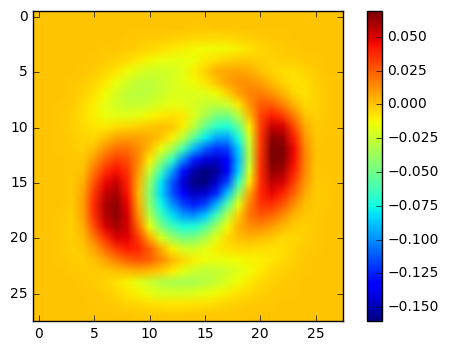

In [42]:
from sklearn.metrics import accuracy_score
y_train_zeros = np.zeros(y_train.shape[0]); y_train_zeros[y_train == 0] = 1;
y_test_zeros = np.zeros(y_test.shape[0]); y_test_zeros[y_test == 0] = 1;

for i in range(5):
    loss_i = train_function(X_train, y_train_zeros)
    print 'loss at iter %i:%.4f' %(i,loss_i)
    print 'train auc:', roc_auc_score(y_train_zeros, sigmoid_function(X_train))
    print 'test auc:', roc_auc_score(y_test_zeros, sigmoid_function(X_test))
    print 'test accuracy:', accuracy_score(y_test_zeros, predict_function(X_test))
    print
print 'resulting weights:'
plt.imshow(shared_weights.get_value().reshape(28,-1))
plt.colorbar();

# Многоклассовая логистическая регрессия

In [43]:
shared_weights = theano.shared(np.zeros((28*28, 10), dtype='float64'))
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='float64')

In [44]:
p_y_given_x = T.nnet.softmax(T.dot(input_X, shared_weights))
y_pred = T.argmax(p_y_given_x, axis=1)
loss = -T.mean(T.log(p_y_given_x)[T.arange(input_y.shape[0]), T.cast(input_y, 'int64')])

softmaxx = T.nnet.nnet.softmax(T.dot(input_X, shared_weights))
pred_func = T.argmax(softmaxx, axis=1)
#loss = T.mean(T.nnet.nnet.categorical_crossentropy(softmaxx, input_y))

grad = T.grad(loss, shared_weights)
update_weights = shared_weights - 0.2 * grad
updates = {
    shared_weights: update_weights }

In [45]:
train_function = theano.function(inputs=[input_X, input_y], outputs = loss, updates=updates)
val_function = theano.function(inputs=[input_X, input_y], outputs = loss)
predict_function = theano.function(inputs = [input_X], outputs = pred_func)

validation loss at beginning: 2.0923
validation accuracy: 0.3967
validation loss at final iter: 0.3034
validation accuracy: 0.9165
Test accuracy 0.9138


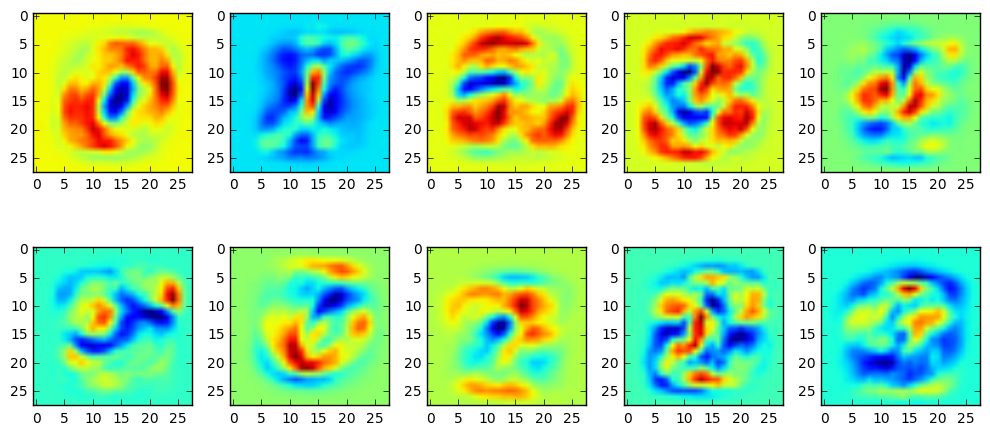

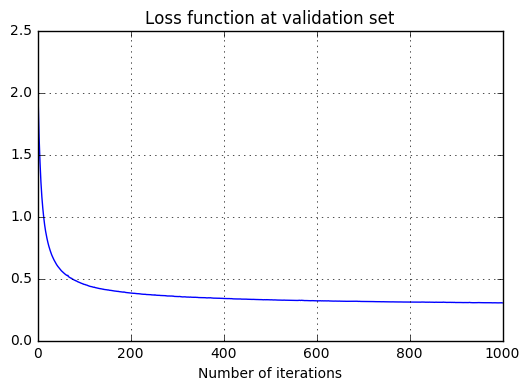

In [46]:
import random
max_iter = 1000
epsilon = 1e-15
count_iter = 0
batch_size = 500
val_losses = []

while count_iter < max_iter:
    count_iter += 1
    ind = random.sample(range(X_train.shape[0]), batch_size)
    train_loss_i = train_function(X_train[ind], y_train[ind])
    val_loss_i = val_function(X_val, y_val)
    val_losses.append(val_loss_i)
    if count_iter == 1:
        print 'validation loss at beginning: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        continue
    elif abs(val_losses[-2] - val_losses[-1]) < epsilon:
        print 'early stopping at iter %i'%(count_iter)
        print 'validation loss: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        break
    elif count_iter == max_iter:
        print 'validation loss at final iter: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        break
print 'Test accuracy', accuracy_score(y_test, predict_function(X_test))

plt.figure(figsize=(10,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    iweights = shared_weights.get_value()[:,i-1]
    plt.imshow(iweights.reshape(28,-1))
plt.tight_layout()
plt.figure()
plt.plot(np.arange(count_iter), val_losses);
plt.grid(); plt.title('Loss function at validation set')
plt.xlabel('Number of iterations')

# Логистическая регрессия со скрытым слоем

In [52]:
weight_hidden = theano.shared(0.01 * np.random.randn(28*28, 50))
weight_output = theano.shared(0.01 * np.random.randn(50, 10))
weights = [weight_hidden, weight_output]
input_X = T.matrix(dtype='float64')
input_y = T.vector(dtype='int64')

In [53]:
sigmoid = T.nnet.nnet.sigmoid(T.dot(input_X, weight_hidden))
softmax = T.nnet.nnet.softmax(T.dot(sigmoid, weight_output))

pred_func = T.argmax(softmax, axis=1)
loss = -T.mean(T.log(softmax)[T.arange(input_y.shape[0]), input_y])

grad = T.grad(loss, weights)

update_weights = [[weight_hidden, weight_hidden - 0.5 * grad[0]],
                  [weight_output, weight_output - 0.5 * grad[1]]]


In [54]:
train_function = theano.function(inputs=[input_X, input_y], outputs = loss, updates=update_weights)
val_function = theano.function(inputs=[input_X, input_y], outputs = loss)
predict_function = theano.function(inputs = [input_X], outputs = pred_func)

validation accuracy: 0.1064
validation loss at beginning: 2.3027
validation accuracy: 0.1064
validation accuracy: 0.1064
validation accuracy: 0.109
validation accuracy: 0.1064
validation accuracy: 0.1064
validation accuracy: 0.103
validation accuracy: 0.109
validation accuracy: 0.1064
validation accuracy: 0.1064
validation accuracy: 0.1064
validation accuracy: 0.103
validation accuracy: 0.1037
validation accuracy: 0.1753
validation accuracy: 0.1064
validation accuracy: 0.0967
validation accuracy: 0.099
validation accuracy: 0.0991
validation accuracy: 0.1064
validation accuracy: 0.1419
validation accuracy: 0.103
validation accuracy: 0.1429
validation accuracy: 0.1852
validation accuracy: 0.2859
validation accuracy: 0.1884
validation accuracy: 0.1064
validation accuracy: 0.1372
validation accuracy: 0.1081
validation accuracy: 0.2685
validation accuracy: 0.127
validation accuracy: 0.1741
validation accuracy: 0.2217
validation accuracy: 0.1819
validation accuracy: 0.1512
validation accurac

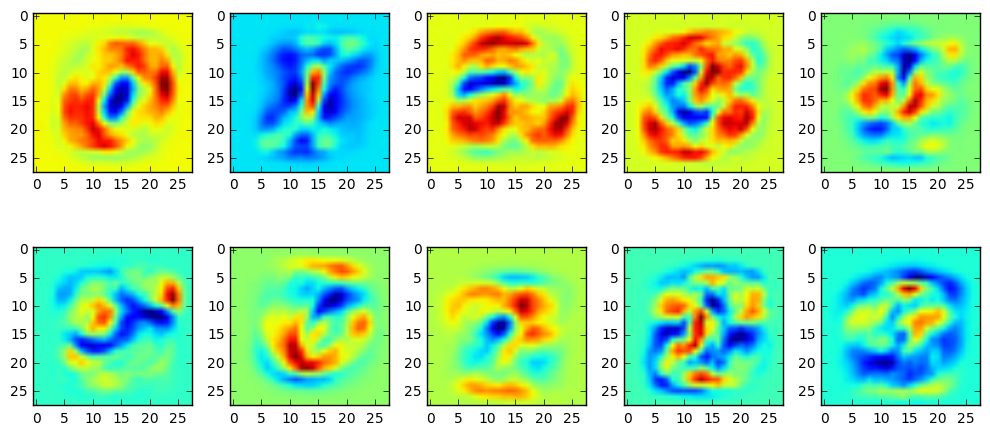

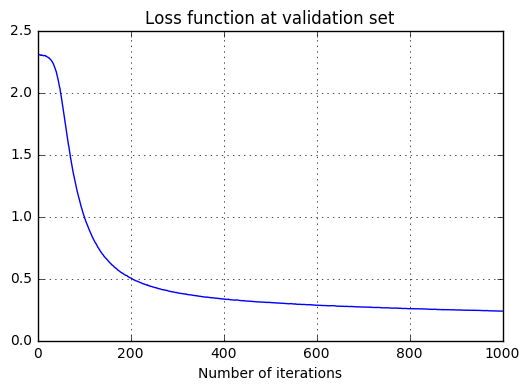

In [55]:
import random
max_iter = 1000
epsilon = 1e-15
count_iter = 0
batch_size = 500
val_losses = []

while count_iter < max_iter:
    count_iter += 1
    ind = random.sample(range(X_train.shape[0]), batch_size)
    train_loss_i = train_function(X_train[ind], y_train[ind])
    val_loss_i = val_function(X_val, y_val)
    val_losses.append(val_loss_i)
    print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
    if count_iter == 1:
        print 'validation loss at beginning: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        continue
    elif abs(val_losses[-2] - val_losses[-1]) < epsilon:
        print 'early stopping at iter %i'%(count_iter)
        print 'validation loss: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        break
    elif count_iter == max_iter:
        print 'validation loss at final iter: %.4f'%(val_loss_i)
        print 'validation accuracy:', accuracy_score(y_val, predict_function(X_val))
        break
print 'Test accuracy', accuracy_score(y_test, predict_function(X_test))

plt.figure(figsize=(10,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    iweights = shared_weights.get_value()[:,i-1]
    plt.imshow(iweights.reshape(28,-1))
plt.tight_layout()
plt.figure()
plt.plot(np.arange(count_iter), val_losses);
plt.grid(); plt.title('Loss function at validation set')
plt.xlabel('Number of iterations')